In [4]:
# 导入模块
import re

import findspark
from pyspark.sql.types import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list

from operator import add

from wordcloud import WordCloud, ImageColorGenerator
import jieba


In [61]:
# ======================== 初始化工作 =========================
# 指明SPARK_HOME
findspark.init("/Users/zhinushannan/environment/spark-3.2.1-bin-hadoop3.2")
# jieba加载自定义字典
jieba.load_userdict("./jieba_dict/dict.txt")
# 新建spark应用
spark = SparkSession.builder.master("local").appName("app").getOrCreate()
sc = spark.sparkContext
# 加载过滤字典
filter_list = []
with open("./jieba_dict/filter_dict.txt") as fp:
    filter_list.extend(fp.read().split("\n"))

In [6]:
# ============================== 数据清洗 ======================================

In [7]:
def filter_logs(line):
    """
    过滤掉“上传文件”、“成员加入”、“成员离开”三类事件
    :param line:
    :return:
    """
    match_upload = re.search(r"(^\[\S+ \S+]) \[INFO]: 群 (\S+) 内 ([\s\S]+) 上传了文件: ([\s\S]+)", line)
    match_member_add = re.search(r"(^\[\S+ \S+]) \[INFO]: 新成员 (\S+) 进入了群 ([\s\S]+)", line)
    match_member_leave = re.search(r"(^\[\S+ \S+]) \[INFO]: 成员 (\S+) 离开了群 ([\s\S]+)", line)

    if match_upload is None and match_member_add is None and match_member_leave is None:
        return True
    else:
        return False


def map_logs(line):
    """
    将过滤后的日志的发消息和收消息的事件构成新的RDD
    :param line:
    :return:
    """
    match_send = re.search(r"(^\[\S+ \S+]) \[INFO]: 发送群 (\S+) 的消息: ([\s\S]+)", line)
    match_get = re.search(r"(^\[\S+ \S+]) \[INFO]: 收到群 (\S+) 内 ([\s\S]+) 的消息: ([\s\S]+)", line)

    if match_send is None and match_get is None:
        return Row(
            time=None,
            group=None,
            user=None,
            message=line,
        )

    if match_send is not None:
        return Row(
            time=match_send.group(1),
            group=match_send.group(2),
            user="self",
            message=match_send.group(3),
        )
    if match_get is not None:
        return Row(
            time=match_get.group(1),
            group=match_get.group(2),
            user=match_get.group(3),
            message=match_get.group(4),
        )

def flat(l):
    """
    构建新自增列
    :param l:
    :return:
    """
    for k in l:
        if not isinstance(k, (list, tuple)):
            yield k
        else:
            yield from flat(k)

def map_remove_message_some(line):
    """
    移除message中除face以外所有的CQ
    :param line:
    :return:
    """
    message = str(line["_4"])
    # 移除 message_id
    message = message[0:message.rfind("(")]
    # 移除 回复 事件
    result = re.compile(r"(\[CQ:\w+,[\w!@#$%^…￥&()_=+-/*\"'‘’“”,.<>?！？《》、：:|\\]+])").findall(message)
    for i in result:
        if "[CQ:face," in i:
            continue
        message = message.replace(i, "")
    message = message.replace(" ", "")
    return Row(
        time=line["_1"],
        group=line["_2"],
        user=line["_3"],
        message=message
    )


def filter_message(line):
    user = str(line["user"])
    message = str(line["message"])

    return user != "self" and len(message) != 0 and "[CQ:json," not in message

In [55]:
# 读取文件
files = sc.textFile("./logs/2022-05-30.log")

for i in range(0, len(files.collect())):
    print(i, files.collect()[i])

0 [2022-05-30 00:10:02] [INFO]: 收到群 20Z计科通知群(540450397) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 熬夜追剧打游戏，趁机打个健康打卡୧⍤⃝
1 ——来自群管理员（1772203969）的编辑 (878587003) 
2 [2022-05-30 01:06:13] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 e组自提(2730993727) 的消息: 有无出修容（液体哒咩） (489589958) 
3 [2022-05-30 01:06:36] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 e组自提(2730993727) 的消息: 出滋色肤色隔离，还有2/3，12r出 (-1919839913) 
4 [2022-05-30 06:00:02] [INFO]: 收到群 21软件3班通知群(684039593) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 早起的你们打卡没？
5 ——来自群管理员（1648866869）的编辑 (187328788) 
6 [2022-05-30 08:00:06] [INFO]: 收到群 20软件1班官方群(927974093) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 穿过挪威的森林，让我走进你的梦里，夕阳落在我的铠甲，王子不一定骑白马，黑马王子四海为家，现在是早上九点整，我不是马思唯，是催打卡的没人陪，打卡！打卡！打卡！！！
7 ——来自群管理员（2741476253）的编辑 (-1763100933) 
8 [2022-05-30 08:01:29] [INFO]: 收到群 21软件2班(626284843) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 新的一天，新的美好，记得❕❗️健康打卡❗️❕[CQ:image,file=6ddeb3e1383d4b40494abdab142c1f04.image,subType=0]
9 ——来自群管理员（3166230258）的编辑 (1287125274) 
10 [2022-05-30 08:19:46] [INFO]: 收到群 潘安湖

78 [2022-05-30 09:28:08] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 出大三数据专业书(2912906799) 的消息: [CQ:image,file=915d6128df1c4a974f86f61862ecc20d.image,subType=0] (-1317241881) 
79 [2022-05-30 09:32:03] [INFO]: 发送群 18软件2班在线群(780548179) 的消息: 健康打卡自动提醒
80 尚 ... (-674972731) 
81 [2022-05-30 09:32:14] [INFO]: 发送群 20Z计科通知群(540450397) 的消息: 健康打卡自动提醒
82 尚 ... (296286090) 
83 [2022-05-30 09:32:25] [INFO]: 发送群 20智能科学与技术(1014806242) 的消息: 健康打卡自动提醒
84 尚 ... (511529012) 
85 [2022-05-30 09:32:36] [INFO]: 发送群 20软件3班通知群(953064865) 的消息: 健康打卡自动提醒
86 尚 ... (1905062980) 
87 [2022-05-30 09:32:46] [INFO]: 发送群 科文学院21Z计科(913765781) 的消息: 健康打卡自动提醒
88 尚 ... (1140838867) 
89 [2022-05-30 09:32:57] [INFO]: 发送群 21数据官方群(673433432) 的消息: 健康打卡自动提醒
90 尚 ... (-1207838355) 
91 [2022-05-30 09:33:08] [INFO]: 发送群 21软件2班(626284843) 的消息: 健康打卡自动提醒
92 尚 ... (-1127256722) 
93 [2022-05-30 09:33:19] [INFO]: 发送群 21软件3班通知群(684039593) 的消息: 健康打卡自动提醒
94 尚 ... (-52919980) 
95 [2022-05-30 09:33:24] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ︶青禾*(2710605724) 的

165 本周青年大学习正常进行。
166 学习完毕后请各位同学将截图发至各自宿舍的小群中，请宿舍长将聊天记录转发到宿舍长群中。 (-12247923) 
167 [2022-05-30 11:26:43] [INFO]: 收到群 20软件3班通知群(953064865) 内 24-刘梦子-团支书(1533808001) 的消息: [CQ:at,qq=all]  (-2008929253) 
168 [2022-05-30 11:26:50] [INFO]: 收到群 21数据官方群(673433432) 内 朱雯雅(2624160598) 的消息: 2022年第14期 青年大学习已开始，请同学们尽快完成，并在今天晚上八点之前把截图私发给我。/喵喵/喵喵/喵喵[CQ:at,qq=all]  (1606022250) 
169 [2022-05-30 11:27:52] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 既出不退(2413544749) 的消息: [CQ:image,file=d256279af17d896b6f0636a06c47dcd7.image,subType=0] (805262953) 
170 [2022-05-30 11:28:50] [INFO]: 收到群 20Z计科通知群(540450397) 内 逯琪    18334883791(1716451970) 的消息: 青年大学习开始了，本周做2022年第14期，按照上周的格式，以宿舍为单位上交，截图于今晚8：00前上交，辛苦大家配合一下按时上交，谢谢！@全体成员  (-5859674) 
171 [2022-05-30 11:28:53] [INFO]: 收到群 18软件2班在线群(780548179) 内 孙仪鹏(1120983676) 的消息: 孙仪鹏生源地信息已核对，无误 (-1612125925) 
172 [2022-05-30 11:30:08] [INFO]: 收到群 18软件2班在线群(780548179) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 还有人没打卡，快看看是不是你😱😱😱「江苏师范大学科文学院信息工程系18软件2班宣」
173 ——来自群管理员（2732160776）的编辑 (115456161) 
1

213 [2022-05-30 11:56:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代拿代买代写代课（期末闭关不接单）(3176627878) 的消息: 出，就用过一次，嘎嘎亮，宿舍小太阳，唯一的缺点就是胶不大粘，自己补点胶就好，10r出[CQ:image,file=c3835fd03805ca7112ed316626bc76d3.image][CQ:image,file=5fcebba93f71136449417e19212abbcd.image] (-1996966015) 
214 [2022-05-30 11:57:51] [INFO]: 收到群 21数据官方群(673433432) 内 魏乐翔(50830046) 的消息: [CQ:json,data={"app":"com.tencent.structmsg"&#44;"config":{"ctime":1653883071&#44;"forward":true&#44;"token":"18e9a934277dc131f3c6151f9883ef25"&#44;"type":"normal"}&#44;"desc":"新闻"&#44;"extra":{"app_type":1&#44;"appid":101458937&#44;"uin":50830046}&#44;"meta":{"news":{"action":""&#44;"android_pkg_name":""&#44;"app_type":1&#44;"appid":101458937&#44;"ctime":1653883071&#44;"desc":"腾讯文档-在线表格"&#44;"jumpUrl":"https://docs.qq.com/sheet/DUlRwSkJhVlpWd25Z"&#44;"preview":"https://docs.idqqimg.com/tim/docs/docs-design-resources/mobile/png@2x/file_sheet_150@2x-379be1fb08.png"&#44;"source_icon":"https://p.qpic.cn/qqconnect/0/app_101458937_1596103559/100?max-age=25

283 [2022-05-30 13:19:45] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: [CQ:image,file=b82418315258cbbd4f761a84c3b2f6b1.image,subType=0] (-1546263486) 
284 [2022-05-30 13:19:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: [CQ:image,file=773bc9514d6875fe7144369b834ea8ab.image,subType=0] (987543032) 
285 [2022-05-30 13:19:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: [CQ:image,file=d0a59d9ccab0f0bf744c503d248076e1.image,subType=0] (1306232174) 
286 [2022-05-30 13:19:50] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: 服装店不干了，全部特价、 (-742453043) 
287 [2022-05-30 13:20:55] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 出租麻将耶(2089325471) 的消息: 这算打广告吗 (-1531436965) 
288 [2022-05-30 13:21:02] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 出租麻将耶(2089325471) 的消息: 我收电竞椅被刷上去了 (1035039201) 
289 [2022-05-30 13:22:10] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: 不算吧、亲，不好意思，你再发一遍，我图片多只是显示衣服风格，全部是处理的， (1253458295) 
290 [2022-05-30 13:22:28] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 

356 [2022-05-30 14:28:15] [INFO]: 新成员 川上赴野(2564717947) 进入了群 潘安湖二手物品转卖群(949682820). 
357 [2022-05-30 14:29:44] [INFO]: 收到群 21软件2班(626284843) 内 王明玮(2990317540) 的消息: 本学期公共课考试时间已出，考场安排等待通知。请同学做好迎考准备，同时请重修、补修的学生，相关考试跟班进行。@全体成员 (-861562399) 
358 [2022-05-30 14:29:53] [INFO]: 群 21软件2班(626284843) 内 王明玮(2990317540) 上传了文件: 附件1：2022年春季学期部分公共课期末考试安排表.doc 
359 [2022-05-30 14:31:01] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: 宏宝莱的没货啊，我再问问 (39571581) 
360 [2022-05-30 14:35:11] [INFO]: 收到群 实干青年 - 老年人活动(369746384) 内 张浩健(1427774041) 的消息: 卧槽 (-1524894237) 
361 [2022-05-30 14:35:19] [INFO]: 收到群 实干青年 - 老年人活动(369746384) 内 张浩健(1427774041) 的消息: 核酸几点结束 (899999858) 
362 [2022-05-30 14:35:55] [INFO]: 收到群 实干青年 - 老年人活动(369746384) 内 宗科(2714871989) 的消息: 现在还没结束 (1118034148) 
363 [2022-05-30 14:36:07] [INFO]: 收到群 实干青年 - 老年人活动(369746384) 内 宗科(2714871989) 的消息: 下午三点半那会就结束了 (576999681) 
364 [2022-05-30 14:36:12] [INFO]: 收到群 实干青年 - 老年人活动(369746384) 内 张浩健(1427774041) 的消息: 行 (1432576407) 
365 [2022-05-30 14:36:17]

430 [2022-05-30 15:45:58] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 对啊 (228966911) 
431 [2022-05-30 15:45:59] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 我靠 (2057498985) 
432 [2022-05-30 15:46:06] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 陆净(1925800532) 的消息: 心理变态吧 (-456760118) 
433 [2022-05-30 15:46:06] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 今天肢解的猫 (-1816046500) 
434 [2022-05-30 15:46:07] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Shotaro Hidari(2055728505) 的消息: 去年不是就有人毒猫的吗 (180880870) 
435 [2022-05-30 15:46:07] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 帅哥1号(2268551581) 的消息: 被撞死也就算了 (2110731632) 
436 [2022-05-30 15:46:09] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 帅哥1号(2268551581) 的消息: 这种 (-311416607) 
437 [2022-05-30 15:46:09] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 那明天是什么 (-1703470985) 
438 [2022-05-30 15:46:11] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Shotaro Hidari(2055728505) 的消息: 在教一 (-930680048) 
439 [2022-0

511 [2022-05-30 15:49:47] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: ？ (1551178317) 
512 [2022-05-30 15:49:49] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b自取(2504715167) 的消息: c是男生啊 (-981709833) 
513 [2022-05-30 15:49:53] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 万(3302817190) 的消息: ？ (-1300530335) 
514 [2022-05-30 15:49:54] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 少时月白(1226102551) 的消息: [CQ:reply,id=-981709833][CQ:at,qq=2504715167] [CQ:at,qq=2504715167] D (740290242) 
515 [2022-05-30 15:49:54] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 被窝哲学家(1911942876) 的消息: c是女生 (1528356436) 
516 [2022-05-30 15:49:55] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: ？ (-1039036434) 
517 [2022-05-30 15:49:56] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 少时月白(1226102551) 的消息: 别乱说 (-1256800392) 
518 [2022-05-30 15:49:56] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组 代抄 代拿 代买 (2889626979) 的消息: c也是女生 (631874281) 
519 [2022-05-30 15:49:57] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 帅哥1号(2268551581) 的消息: c女的 (

584 [2022-05-30 15:52:37] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 两个月好像 (-1438279622) 
585 [2022-05-30 15:52:42] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组团(3361457907) 的消息: 嗯 (-582834004) 
586 [2022-05-30 15:52:44] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 女孩子也砍的动？ (1145829654) 
587 [2022-05-30 15:52:49] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组团(3361457907) 的消息: 是小崽 (860670336) 
588 [2022-05-30 15:52:52] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 emo怪(1326768287) 的消息: 要是abcd都有那个残肢的话.. (-1544301551) 
589 [2022-05-30 15:52:55] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: ！ (-722148217) 
590 [2022-05-30 15:52:57] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 emo怪(1326768287) 的消息: 可能真的心理变态 (-1271698078) 
591 [2022-05-30 15:53:04] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: 我们这里潜藏一个 (-1019978252) 
592 [2022-05-30 15:53:08] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: 危险分子 (1513950286) 
593 [2022-05-30 15:53:

667 [2022-05-30 16:07:37] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 筱二不爱挂科(3084001365) 的消息: 都分散尸体了 (-1707784991) 
668 [2022-05-30 16:07:39] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 筱二不爱挂科(3084001365) 的消息: ？ (-315460489) 
669 [2022-05-30 16:07:41] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 大概这里 (1950033357) 
670 [2022-05-30 16:07:54] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 好像猫头也不是不可能那么正/汪汪 (54269275) 
671 [2022-05-30 16:07:57] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 这是b组团的视角 (-1820129078) 
672 [2022-05-30 16:08:00] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 在地上 (-461096868) 
673 [2022-05-30 16:08:04] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 而且刚好在路边 (-2075938375) 
674 [2022-05-30 16:08:13] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 一粒暗淡星.(3169862712) 的消息: 太正了 (-213614289) 
675 [2022-05-30 16:08:14] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 树子边 (1783484565) 
676 [2022-05-30 16:08:24] [INFO]: 收到群 潘安湖二手物品转卖群(949682

748 [2022-05-30 16:23:05] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 私貘(2718554774) 的消息: 让他被开除！！ (2028228400) 
749 [2022-05-30 16:23:10] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 这种人也没有必要帮他遮遮掩掩 (-427763053) 
750 [2022-05-30 16:23:12] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: 无法防范 (-1853363707) 
751 [2022-05-30 16:23:12] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 对！ (143571903) 
752 [2022-05-30 16:23:13] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 🍓(2441186869) 的消息: 心理指定有问题 (2139720489) 
753 [2022-05-30 16:23:14] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 私貘(2718554774) 的消息: 档案留污点！ (-281635144) 
754 [2022-05-30 16:23:19] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 私貘(2718554774) 的消息: 留案底！ (-1741576658) 
755 [2022-05-30 16:23:20] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 真的是心理有问题 (-893366967) 
756 [2022-05-30 16:23:24] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 私貘(2718554774) 的消息: 太可怕了 (-1110999585) 
757 [2022-05-30 16:23:29] [INFO]: 收到群 潘安湖二手物品转卖群(949682

829 [2022-05-30 16:37:32] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 efgh代买代拿(1124740374) 的消息: 发生了啥 (777605275) 
830 [2022-05-30 16:37:36] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 efgh代买代拿(1124740374) 的消息: [CQ:image,file=b851980dfbffdae78cedacaf73262441.image,subType=1] (1499357197) 
831 [2022-05-30 16:37:44] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: [CQ:image,file=724518eaae43adfeb98d417bebe323c6.image,subType=0] (-1068027465) 
832 [2022-05-30 16:37:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 这时候发个这个 (-1219493599) 
833 [2022-05-30 16:37:49] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 真的🤡啊 (669981872) 
834 [2022-05-30 16:38:15] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 A代刷网课 出脚本 期末线上题库 猴博士全套(851949205) 的消息: [CQ:reply,id=777605275][CQ:at,qq=1124740374] [CQ:at,qq=1124740374] 往上面翻 (1357392934) 
835 [2022-05-30 16:40:41] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 软软(534083587) 的消息: 给院长发[CQ:image,file=5e8bc5973bc7aa46fe229fe8bfa65741.image,subType=0] (-206935818) 
836 [2022

898 [2022-05-30 16:50:25] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代拿代买代写代课（期末闭关不接单）(3176627878) 的消息: 快去 (-150920169) 
899 [2022-05-30 16:50:28] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代买代写代拿快递(3357117106) 的消息: 好 (-1510944912) 
900 [2022-05-30 16:50:29] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 肉肉(3270682323) 的消息: 太可怕了 (-755499034) 
901 [2022-05-30 16:50:30] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: 自己去拿 (1274981980) 
902 [2022-05-30 16:50:32] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代拿代买代写代课（期末闭关不接单）(3176627878) 的消息: 我给你收衣服 (1022992074) 
903 [2022-05-30 16:50:32] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: /汪汪/汪汪 (-1566766231) 
904 [2022-05-30 16:50:39] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代买代写代拿快递(3357117106) 的消息: 菩萨在人间！ (-711312385) 
905 [2022-05-30 16:50:47] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代拿代买代写代课（期末闭关不接单）(3176627878) 的消息: 笑死我了 (1284729413) 
906 [2022-05-30 16:50:50] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: /捂脸/捂脸 (999578323) 
907 [2022-05-30 16:50

976 
977 【招聘入群链接，需手机端打开】https://wj.qq.com/s2/10283407/a51c/
978 
979  【企业名称】上海诺行信息技术有限公司
980 
981 【企业介绍】 诺行2010年成立于上海，是技术领先的LTE数据和IOT/M2M设备及服务提供商，诺行拥有热诚的员工和强大的研发能力，拥有21个自有专利， 产品服务于全球40多个国家和地区的客户。 公司主要业务为LTE数据产品、物联网产品、TR069整体服务方案，相关产品完全自主研发，产品销售遍布全球五大洲超过100个国家，拥有良好的产品品质和极低的不良率，并与全球运营商和知名品牌建立了合作关系。公司注重人性化管理，希望员工与公司能够共同成长，共同进步。当前公司正处于爆发式发展期，我们求贤若渴，希望具有创业精神、挑战精神以及喜爱研发的优秀人才同我们一起开创未来。 
982 
983 【招聘岗位及任职要求】
984 1、嵌入式软件开发工程师
985 专业需求：计算机/电子工程/通信及相关专业毕业；
986 2、Java开发工程师
987  专业需求：计算机/电子工程/通信及相关专业毕业；
988 3、基带/硬件工程师
989 专业需求：通信/电子/自动控制等相关专业；
990 4、软件测试工程师
991 专业需求：计算机/电子工程/通信及相关专业毕业；
992 5、硬件测试工程师
993 专业需求：计算机相关专业
994 6、Linux平台开发工程师
995 专业需求：计算机/电子工程/通信及相关专业毕业；
996 7、Linux应用开发工程师
997 专业需求：计算机/电子工程/通信及相关专业毕业；
998 8、射频工程师
999 专业需求：电子工程、通信、微波等相关专业；
1000 
1001 【薪资待遇】
1002 1、实习五天八小时工作制；
1003 2、丰富的薪资架构体系（基本薪资+绩效奖金+项目奖金+长期激励）；
1004 3、入职提供完善的五险一金保障；
1005 4、餐补、差旅补等各项补贴；每月之星奖、项目奖、绩效奖等奖励；
1006 5、提供全面、系统、专业的培训；
1007 6、提供广阔的职业发展空间与提升机会；
1008 7、细致入微的员工关怀（如员工部门团建活动、阳光下午茶、体育活动、年度旅游、团队拓展等）。
1009 
1010 【工作地点】
1011

1069 [2022-05-30 19:01:21] [INFO]: 收到群 20Z计科通知群(540450397) 内 辅导员——王群(953060053) 的消息: 毕业季，群内通知都很重要，也很紧急，请各位同学务必及时关注群消息，不看，看了不回会增加老师很大的工作量。自己的事情自己要上心，马上要走上社会了，社会人没有那么多人迁就大家，或者一再给大家补救机会。请大家换位思考[CQ:at,qq=all]  (1227479102) 
1070 [2022-05-30 19:02:23] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 梦里花落知多少(917134951) 的消息: 9元[CQ:image,file=6aa45894c044b35e15395d7b9cd7a8dd.image,subType=0] (-567765733) 
1071 [2022-05-30 19:06:57] [INFO]: 收到群 20Z计科通知群(540450397) 内 卢涛15651795271(1905155053) 的消息: 收到 (1043261608) 
1072 [2022-05-30 19:07:20] [INFO]: 收到群 20Z计科通知群(540450397) 内 于小楚(728514179) 的消息: 收到 (1592353101) 
1073 [2022-05-30 19:09:56] [INFO]: 收到群 新蜂生活超市(854452883) 内 攒原石抽七七(2539932185) 的消息: /托脸这边可以送东西到隔离宿舍嘛 (97627209) 
1074 [2022-05-30 19:11:51] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: [CQ:reply,id=97627209][CQ:at,qq=2539932185] [CQ:at,qq=2539932185] 可以 (1926667487) 
1075 [2022-05-30 19:13:22] [INFO]: 收到群 新蜂生活超市(854452883) 内 攒原石抽七七(2539932185) 的消息: 好的 (-337654427) 
1076 [2022-05-30 19:15:09] [

1141 [2022-05-30 20:08:31] [INFO]: 收到群 新蜂生活超市(854452883) 内 傅彤(80000000) 的消息: 不是很能理解 (2104138337) 
1142 [2022-05-30 20:08:37] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 那边还有篮球场啊 (-304773136) 
1143 [2022-05-30 20:08:49] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 正常都是走那条路过的 (-1697466522) 
1144 [2022-05-30 20:08:54] [INFO]: 收到群 新蜂生活超市(854452883) 内 陆逊(80000000) 的消息: 会不会在宿舍搞好了，然后阳台扔下去的 (-1404069627) 
1145 [2022-05-30 20:09:11] [INFO]: 收到群 新蜂生活超市(854452883) 内 温情.(2268551581) 的消息: 妈呀 (-615994989) 
1146 [2022-05-30 20:09:33] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 那宿舍人不会不懂吧 (1111619625) 
1147 [2022-05-30 20:09:36] [INFO]: 收到群 新蜂生活超市(854452883) 内 赵忠(80000000) 的消息: 凶手还没揪出来，就先把事情按在女的头上？ (893831359) 
1148 [2022-05-30 20:10:32] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 真的拴Q (-1423811300) 
1149 [2022-05-30 20:10:34] [INFO]: 收到群 新蜂生活超市(854452883) 内 诸葛瑾(80000000) 的消息: 都说了，大概率，谁也不希望女孩子是凶手啊，那得多恐怖 (-601526902) 
1150 [2022-05-30 20:10:54] [INFO]: 收到群 新蜂生活超市(85445

1212 [2022-05-30 20:52:08] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 有人说是车压的 (434235208) 
1213 [2022-05-30 20:52:17] [INFO]: 收到群 新蜂生活超市(854452883) 内 当 当 当 duang duang duang(1043618032) 的消息: 应该是车压的 (1860622302) 
1214 [2022-05-30 20:52:17] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 可是车压了的猫不应该是那样的 (-135297436) 
1215 [2022-05-30 20:52:25] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 妈的 (-2132232462) 
1216 [2022-05-30 20:52:28] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 肚子那一条缝好像是 (512500561) 
1217 [2022-05-30 20:52:28] [INFO]: 收到群 新蜂生活超市(854452883) 内 当 当 当 duang duang duang(1043618032) 的消息: 要不就是下药了 (1770722247) 
1218 [2022-05-30 20:52:32] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 对的 (-259898755) 
1219 [2022-05-30 20:52:39] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 你也怀疑是的 (-2021297429) 
1220 [2022-05-30 20:53:05] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 我见过车压的，会成一层皮那种…… (389705594) 
1221 [2022-05-30 20:53:14] [INFO]: 收到群 新蜂生活超市(854

1290 [2022-05-30 21:38:26] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Lau(398196081) 的消息: 支付宝哪里呀 (606127548) 
1291 [2022-05-30 21:39:50] [INFO]: 收到群 20Z计科通知群(540450397) 内 逯琪    18334883791(1716451970) 的消息: [CQ:image,file=caecfc9f85b1557a644c7f35c031316d.image,subType=0]没交的请尽快，还有7个人未交 (780375490) 
1292 [2022-05-30 21:39:52] [INFO]: 收到群 20Z计科通知群(540450397) 内 逯琪    18334883791(1716451970) 的消息: [CQ:at,qq=all] (-1215642504) 
1293 [2022-05-30 21:40:18] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: [CQ:reply,id=1519952735]好像还有 (-1275394454) 
1294 [2022-05-30 21:42:18] [INFO]: 收到群 新蜂生活超市(854452883) 内 Glimmering.AN(2677477571) 的消息: [CQ:reply,id=-1013845275][CQ:at,qq=105070597] 鸭脖咩 (-990103812) 
1295 [2022-05-30 21:42:37] [INFO]: 收到群 新蜂生活超市(854452883) 内 Glimmering.AN(2677477571) 的消息: [CQ:image,file=73d5a51c354467e819e0ac99da36b95d.image,subType=0] (1576363846) 
1296 [2022-05-30 21:43:02] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: 这还差不多[CQ:face,id=13] (720525264) 
1297 [2022-05-30 2

1361 [2022-05-30 22:17:53] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 萝卜(3355831528) 的消息: 求618凑单 (617053585) 
1362 [2022-05-30 22:20:58] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: 明天问下 (-1741558396) 
1363 [2022-05-30 22:21:20] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: 脱肥不香嘛？/斜眼笑 (106264615) 
1364 [2022-05-30 22:21:24] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 E(2467243936) 的消息: 收Dior气垫替换芯14g (1405111559) 
1365 [2022-05-30 22:21:37] [INFO]: 收到群 新蜂生活超市(854452883) 内 李催(80000000) 的消息: 东雪莲 (1901217969) 
1366 [2022-05-30 22:21:51] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 15(723170725) 的消息: 收生理盐水 f (-892789571) 
1367 [2022-05-30 22:24:20] [INFO]: 收到群 20Z计科通知群(540450397) 内 于小楚(728514179) 的消息: 好了。 (1826554831) 
1368 [2022-05-30 22:26:24] [INFO]: 收到群 新蜂生活超市(854452883) 内 懒羊羊(1834808612) 的消息: 我记得有个雪碧味儿的冰球球 (-396682997) 
1369 [2022-05-30 22:26:31] [INFO]: 收到群 新蜂生活超市(854452883) 内 懒羊羊(1834808612) 的消息: 但是不记得叫啥啊 (-1621349987) 
1370 [2022-05-30 22:26:37] [INFO]: 收到群 新蜂生活超市(854452883) 内 懒羊羊(183480

1421 [2022-05-30 22:48:07] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1422 [2022-05-30 22:48:10] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1423 [2022-05-30 22:48:10] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1424 [2022-05-30 22:48:13] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1425 [2022-05-30 22:48:13] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1426 [2022-05-30 22:48:16] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1427 [2022-05-30 22:48:16] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
142

1487 [2022-05-30 22:49:46] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1488 [2022-05-30 22:49:49] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1489 [2022-05-30 22:49:49] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1490 [2022-05-30 22:49:52] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1491 [2022-05-30 22:49:52] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1492 [2022-05-30 22:49:55] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1493 [2022-05-30 22:49:55] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
149

1554 [2022-05-30 22:51:28] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1555 [2022-05-30 22:51:28] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1556 [2022-05-30 22:51:31] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1557 [2022-05-30 22:51:31] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1558 [2022-05-30 22:51:34] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1559 [2022-05-30 22:51:34] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1560 [2022-05-30 22:51:37] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1561 [2022-05-30 22:51:37] [WARNING]: 连接到反向WebSocket Universal服务器

1622 [2022-05-30 22:53:10] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1623 [2022-05-30 22:53:10] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1624 [2022-05-30 22:53:13] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1625 [2022-05-30 22:53:13] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1626 [2022-05-30 22:53:16] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1627 [2022-05-30 22:53:16] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1628 [2022-05-30 22:53:19] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1629 [2022-05-30 22:53:19] [WARNING]: 连接到反向WebSocket Universal服务器

1683 [2022-05-30 22:54:40] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1684 [2022-05-30 22:54:43] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1685 [2022-05-30 22:54:43] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1686 [2022-05-30 22:54:46] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1687 [2022-05-30 22:54:46] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1688 [2022-05-30 22:54:49] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1689 [2022-05-30 22:54:49] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
169

1743 [2022-05-30 22:56:10] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1744 [2022-05-30 22:56:13] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1745 [2022-05-30 22:56:13] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1746 [2022-05-30 22:56:16] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1747 [2022-05-30 22:56:16] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1748 [2022-05-30 22:56:19] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1749 [2022-05-30 22:56:19] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
175

1804 [2022-05-30 22:57:40] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1805 [2022-05-30 22:57:40] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1806 [2022-05-30 22:57:43] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1807 [2022-05-30 22:57:43] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1808 [2022-05-30 22:57:46] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1809 [2022-05-30 22:57:46] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1810 [2022-05-30 22:57:49] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1811 [2022-05-30 22:57:49] [WARNING]: 连接到反向WebSocket Universal服务器

1856 [2022-05-30 22:58:55] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1857 [2022-05-30 22:58:58] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1858 [2022-05-30 22:58:58] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1859 [2022-05-30 22:59:01] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1860 [2022-05-30 22:59:01] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1861 [2022-05-30 22:59:04] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1862 [2022-05-30 22:59:04] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
186

1924 [2022-05-30 23:00:37] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1925 [2022-05-30 23:00:40] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1926 [2022-05-30 23:00:40] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1927 [2022-05-30 23:00:43] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1928 [2022-05-30 23:00:43] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1929 [2022-05-30 23:00:46] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1930 [2022-05-30 23:00:46] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
193

1993 [2022-05-30 23:02:22] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1994 [2022-05-30 23:02:22] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1995 [2022-05-30 23:02:25] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1996 [2022-05-30 23:02:25] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1997 [2022-05-30 23:02:28] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1998 [2022-05-30 23:02:28] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1999 [2022-05-30 23:02:31] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2000 [2022-05-30 23:02:31] [WARNING]: 连接到反向WebSocket Universal服务器

2055 [2022-05-30 23:03:55] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2056 [2022-05-30 23:03:55] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2057 [2022-05-30 23:03:58] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2058 [2022-05-30 23:03:58] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2059 [2022-05-30 23:04:01] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2060 [2022-05-30 23:04:01] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2061 [2022-05-30 23:04:04] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2062 [2022-05-30 23:04:04] [WARNING]: 连接到反向WebSocket Universal服务器

2124 [2022-05-30 23:05:38] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2125 [2022-05-30 23:05:41] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2126 [2022-05-30 23:05:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2127 [2022-05-30 23:05:44] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2128 [2022-05-30 23:05:44] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2129 [2022-05-30 23:05:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2130 [2022-05-30 23:05:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
213

2186 [2022-05-30 23:07:11] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2187 [2022-05-30 23:07:14] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2188 [2022-05-30 23:07:14] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2189 [2022-05-30 23:07:17] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2190 [2022-05-30 23:07:17] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2191 [2022-05-30 23:07:20] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2192 [2022-05-30 23:07:20] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
219

2254 [2022-05-30 23:08:53] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2255 [2022-05-30 23:08:56] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2256 [2022-05-30 23:08:56] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2257 [2022-05-30 23:08:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2258 [2022-05-30 23:08:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2259 [2022-05-30 23:09:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2260 [2022-05-30 23:09:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
226

2318 [2022-05-30 23:10:26] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2319 [2022-05-30 23:10:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2320 [2022-05-30 23:10:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2321 [2022-05-30 23:10:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2322 [2022-05-30 23:10:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2323 [2022-05-30 23:10:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2324 [2022-05-30 23:10:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2325 [2022-05-30 23:10:35] [WARNING]: 连接到反向WebSocket Universal服务器

2387 [2022-05-30 23:12:08] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2388 [2022-05-30 23:12:11] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2389 [2022-05-30 23:12:11] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2390 [2022-05-30 23:12:14] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2391 [2022-05-30 23:12:14] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2392 [2022-05-30 23:12:17] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2393 [2022-05-30 23:12:17] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
239

2447 [2022-05-30 23:13:38] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2448 [2022-05-30 23:13:41] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2449 [2022-05-30 23:13:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2450 [2022-05-30 23:13:44] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2451 [2022-05-30 23:13:44] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2452 [2022-05-30 23:13:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2453 [2022-05-30 23:13:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
245

2516 [2022-05-30 23:15:23] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2517 [2022-05-30 23:15:23] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2518 [2022-05-30 23:15:26] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2519 [2022-05-30 23:15:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2520 [2022-05-30 23:15:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2521 [2022-05-30 23:15:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2522 [2022-05-30 23:15:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2523 [2022-05-30 23:15:32] [WARNING]: 连接到反向WebSocket Universal服务器

2580 [2022-05-30 23:16:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2581 [2022-05-30 23:16:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2582 [2022-05-30 23:17:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2583 [2022-05-30 23:17:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2584 [2022-05-30 23:17:05] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2585 [2022-05-30 23:17:05] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2586 [2022-05-30 23:17:08] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2587 [2022-05-30 23:17:08] [WARNING]: 连接到反向WebSocket Universal服务器

2642 [2022-05-30 23:18:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2643 [2022-05-30 23:18:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2644 [2022-05-30 23:18:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2645 [2022-05-30 23:18:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2646 [2022-05-30 23:18:35] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2647 [2022-05-30 23:18:38] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2648 [2022-05-30 23:18:38] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
264

2702 [2022-05-30 23:19:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2703 [2022-05-30 23:20:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2704 [2022-05-30 23:20:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2705 [2022-05-30 23:20:05] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2706 [2022-05-30 23:20:05] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2707 [2022-05-30 23:20:08] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2708 [2022-05-30 23:20:08] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
270

2769 [2022-05-30 23:21:41] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2770 [2022-05-30 23:21:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2771 [2022-05-30 23:21:44] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2772 [2022-05-30 23:21:44] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2773 [2022-05-30 23:21:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2774 [2022-05-30 23:21:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2775 [2022-05-30 23:21:50] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2776 [2022-05-30 23:21:50] [WARNING]: 连接到反向WebSocket Universal服务器

2831 [2022-05-30 23:23:14] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2832 [2022-05-30 23:23:14] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2833 [2022-05-30 23:23:17] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2834 [2022-05-30 23:23:17] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2835 [2022-05-30 23:23:20] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2836 [2022-05-30 23:23:20] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2837 [2022-05-30 23:23:23] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2838 [2022-05-30 23:23:23] [WARNING]: 连接到反向WebSocket Universal服务器

2900 [2022-05-30 23:24:55] [INFO]: 收到群 新蜂生活超市(854452883) 内 高顺(80000000) 的消息: 冰杨梅+1 (1170396649) 
2901 [2022-05-30 23:24:56] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2902 [2022-05-30 23:24:56] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2903 [2022-05-30 23:24:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2904 [2022-05-30 23:24:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2905 [2022-05-30 23:25:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2906 [2022-05-30 23:25:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2907 [2022-05-30 23:25:05] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49

2960 [2022-05-30 23:26:23] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2961 [2022-05-30 23:26:26] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2962 [2022-05-30 23:26:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2963 [2022-05-30 23:26:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2964 [2022-05-30 23:26:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2965 [2022-05-30 23:26:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2966 [2022-05-30 23:26:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
296

3020 [2022-05-30 23:27:53] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3021 [2022-05-30 23:27:56] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3022 [2022-05-30 23:27:56] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3023 [2022-05-30 23:27:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3024 [2022-05-30 23:27:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3025 [2022-05-30 23:28:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3026 [2022-05-30 23:28:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
302

3081 [2022-05-30 23:29:23] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3082 [2022-05-30 23:29:26] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3083 [2022-05-30 23:29:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3084 [2022-05-30 23:29:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3085 [2022-05-30 23:29:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3086 [2022-05-30 23:29:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3087 [2022-05-30 23:29:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
308

3141 [2022-05-30 23:30:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3142 [2022-05-30 23:30:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3143 [2022-05-30 23:30:50] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3144 [2022-05-30 23:30:50] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3145 [2022-05-30 23:30:53] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组团(2465397940) 的消息: 嘎嘎嘎 (896510628) 
3146 [2022-05-30 23:30:53] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3147 [2022-05-30 23:30:53] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3148 [2022-05-30 23:30:56] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws:

3208 [2022-05-30 23:32:26] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3209 [2022-05-30 23:32:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3210 [2022-05-30 23:32:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3211 [2022-05-30 23:32:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3212 [2022-05-30 23:32:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3213 [2022-05-30 23:32:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3214 [2022-05-30 23:32:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3215 [2022-05-30 23:32:35] [WARNING]: 连接到反向WebSocket Universal服务器

3269 [2022-05-30 23:33:56] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3270 [2022-05-30 23:33:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3271 [2022-05-30 23:33:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3272 [2022-05-30 23:34:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3273 [2022-05-30 23:34:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3274 [2022-05-30 23:34:05] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3275 [2022-05-30 23:34:05] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
327

3330 [2022-05-30 23:35:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3331 [2022-05-30 23:35:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3332 [2022-05-30 23:35:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3333 [2022-05-30 23:35:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3334 [2022-05-30 23:35:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3335 [2022-05-30 23:35:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3336 [2022-05-30 23:35:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
333

3392 [2022-05-30 23:37:00] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3393 [2022-05-30 23:37:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3394 [2022-05-30 23:37:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3395 [2022-05-30 23:37:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3396 [2022-05-30 23:37:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3397 [2022-05-30 23:37:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3398 [2022-05-30 23:37:09] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
339

3461 [2022-05-30 23:38:42] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3462 [2022-05-30 23:38:42] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3463 [2022-05-30 23:38:45] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3464 [2022-05-30 23:38:45] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3465 [2022-05-30 23:38:48] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3466 [2022-05-30 23:38:48] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3467 [2022-05-30 23:38:51] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3468 [2022-05-30 23:38:51] [WARNING]: 连接到反向WebSocket Universal服务器

3530 [2022-05-30 23:40:21] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3531 [2022-05-30 23:40:24] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3532 [2022-05-30 23:40:24] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3533 [2022-05-30 23:40:27] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3534 [2022-05-30 23:40:27] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3535 [2022-05-30 23:40:30] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3536 [2022-05-30 23:40:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
353

3598 [2022-05-30 23:42:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3599 [2022-05-30 23:42:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3600 [2022-05-30 23:42:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3601 [2022-05-30 23:42:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3602 [2022-05-30 23:42:09] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3603 [2022-05-30 23:42:12] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3604 [2022-05-30 23:42:12] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
360

3657 [2022-05-30 23:43:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3658 [2022-05-30 23:43:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3659 [2022-05-30 23:43:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3660 [2022-05-30 23:43:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3661 [2022-05-30 23:43:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3662 [2022-05-30 23:43:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3663 [2022-05-30 23:43:39] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
366

3718 [2022-05-30 23:45:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3719 [2022-05-30 23:45:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3720 [2022-05-30 23:45:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3721 [2022-05-30 23:45:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3722 [2022-05-30 23:45:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3723 [2022-05-30 23:45:09] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3724 [2022-05-30 23:45:12] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3725 [2022-05-30 23:45:12] [WARNING]: 连接到反向WebSocket Universal服务器

3780 [2022-05-30 23:46:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3781 [2022-05-30 23:46:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3782 [2022-05-30 23:46:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3783 [2022-05-30 23:46:39] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3784 [2022-05-30 23:46:42] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3785 [2022-05-30 23:46:42] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3786 [2022-05-30 23:46:45] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3787 [2022-05-30 23:46:45] [WARNING]: 连接到反向WebSocket Universal服务器

3840 [2022-05-30 23:48:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3841 [2022-05-30 23:48:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3842 [2022-05-30 23:48:08] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Big正(1446982638) 的消息: [CQ:image,file=ca915723675669f95d64973b00627ecb.image,subType=0] (1020913295) 
3843 [2022-05-30 23:48:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3844 [2022-05-30 23:48:09] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3845 [2022-05-30 23:48:12] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Big正(1446982638) 的消息: 45 (1545498474) 
3846 [2022-05-30 23:48:12] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3847 [2022-05-30 23:48:12] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.2

3902 [2022-05-30 23:49:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3903 [2022-05-30 23:49:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3904 [2022-05-30 23:49:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3905 [2022-05-30 23:49:39] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3906 [2022-05-30 23:49:42] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3907 [2022-05-30 23:49:42] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3908 [2022-05-30 23:49:45] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3909 [2022-05-30 23:49:45] [WARNING]: 连接到反向WebSocket Universal服务器

3967 [2022-05-30 23:51:12] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3968 [2022-05-30 23:51:15] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3969 [2022-05-30 23:51:15] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3970 [2022-05-30 23:51:17] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组团(2465397940) 的消息: 我舍友的长这样 (723083260) 
3971 [2022-05-30 23:51:18] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3972 [2022-05-30 23:51:18] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3973 [2022-05-30 23:51:21] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组团(2465397940) 的消息: 我的可大 (-1307570618) 
3974 [2022-05-30 23:51:21] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws

4028 [2022-05-30 23:52:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4029 [2022-05-30 23:52:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4030 [2022-05-30 23:52:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4031 [2022-05-30 23:52:35] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Big正(1446982638) 的消息: 双倍快乐吗 (1999846569) 
4032 [2022-05-30 23:52:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4033 [2022-05-30 23:52:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4034 [2022-05-30 23:52:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4035 [2022-05-30 23:52:39] [WARNING]: 连接到反向WebSocket Universal服务器 w

4088 [2022-05-30 23:53:57] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4089 [2022-05-30 23:53:57] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4090 [2022-05-30 23:54:00] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4091 [2022-05-30 23:54:00] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4092 [2022-05-30 23:54:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4093 [2022-05-30 23:54:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4094 [2022-05-30 23:54:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4095 [2022-05-30 23:54:06] [WARNING]: 连接到反向WebSocket Universal服务器

4150 [2022-05-30 23:55:27] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4151 [2022-05-30 23:55:30] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4152 [2022-05-30 23:55:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4153 [2022-05-30 23:55:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4154 [2022-05-30 23:55:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4155 [2022-05-30 23:55:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4156 [2022-05-30 23:55:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
415

4219 [2022-05-30 23:57:12] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4220 [2022-05-30 23:57:12] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4221 [2022-05-30 23:57:15] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4222 [2022-05-30 23:57:15] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4223 [2022-05-30 23:57:18] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4224 [2022-05-30 23:57:18] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4225 [2022-05-30 23:57:21] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4226 [2022-05-30 23:57:21] [WARNING]: 连接到反向WebSocket Universal服务器

4282 [2022-05-30 23:58:45] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4283 [2022-05-30 23:58:48] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4284 [2022-05-30 23:58:48] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4285 [2022-05-30 23:58:51] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4286 [2022-05-30 23:58:51] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4287 [2022-05-30 23:58:54] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4288 [2022-05-30 23:58:54] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
428

In [56]:
# 数据清洗：将消息日志转为dataframe

logs = files.filter(filter_logs).map(map_logs)
logs_df = logs.toDF()
print(type(logs_df))
logs_df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+------------------------------+--------------------+-------------------------------+
|                time|                         group|                user|                        message|
+--------------------+------------------------------+--------------------+-------------------------------+
|[2022-05-30 00:10...|      20Z计科通知群(540450397)| Q群管家(2854196310)|         [CQ:at,qq=all] 熬夜...|
|                null|                          null|                null|    ——来自群管理员（17722039...|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...| e组自提(2730993727)|有无出修容（液体哒咩） (4895...|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...| e组自提(2730993727)|出滋色肤色隔离，还有2/3，12r...|
|[2022-05-30 06:00...|    21软件3班通知群(684039593)| Q群管家(2854196310)|         [CQ:at,qq=all] 早起...|
|                null|                          null|                null|    ——来自群管理员（16488668...|
|[2022-05-30 08:00...|    20软件1班官方群(927974093)| Q群管家(2854196310)|         [CQ:

In [57]:
"""  合并换行的消息  """
logs_rdd = logs_df.rdd.zipWithIndex()
logs_rdd = logs_rdd.map(lambda x: list(flat(x)))
i = 0
logs_list = logs_rdd.collect()
while i < len(logs_list):
    if i + 1 < len(logs_list) and logs_list[i + 1][0] is None:
        logs_list[i][3] += logs_list[i + 1][3]
        logs_list.pop(i + 1)
    else:
        i += 1

logs_table = spark.createDataFrame(data=logs_list).rdd.map(map_remove_message_some).filter(filter_message).toDF()
logs_table.show()

+--------------------+------------------------------+---------------------------+-------------------------------------+
|                time|                         group|                       user|                              message|
+--------------------+------------------------------+---------------------------+-------------------------------------+
|[2022-05-30 00:10...|      20Z计科通知群(540450397)|        Q群管家(2854196310)| 熬夜追剧打游戏，趁机打个健康打卡୧...|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...|        e组自提(2730993727)|               有无出修容（液体哒咩）|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...|        e组自提(2730993727)|       出滋色肤色隔离，还有2/3，12r出|
|[2022-05-30 06:00...|    21软件3班通知群(684039593)|        Q群管家(2854196310)|  早起的你们打卡没？——来自群管理员...|
|[2022-05-30 08:00...|    20软件1班官方群(927974093)|        Q群管家(2854196310)|穿过挪威的森林，让我走进你的梦里，...|
|[2022-05-30 08:01...|          21软件2班(626284843)|        Q群管家(2854196310)|   新的一天，新的美好，记得❕❗️健康...|
|[2022-05-30 08:19...|潘安湖二手物品转卖群(949682...|             25(1730

In [ ]:
# ============================== 词云统计 ======================================

In [30]:
def map_remove_face_cq(line):
    message = str(line["message"])
    result = re.compile(r"(\[CQ:face,id=(\d+)])").findall(str(message))
    for i in result:
        message.replace(i[0], "")
    return message


def map_jieba(line):
    jieba_result = jieba.cut(line)
    result = []
    for i in jieba_result:
        result.append(i)
    jieba_result = jieba.cut(line, cut_all=True)
    all = []
    for i in jieba_result:
        all.append(i)
    return Row(
        raw=line,
        # cut_hmm=str(result)[1:-1],
        # cut_all=str(all)[1:-1],
        cut_hmm=result,
        cut_all=all,
        id=1
    )


def filter_dict(line):
    key = line[0]
    if key in filter_list:
        return False
    return True

In [59]:
# 筛选对应群聊、删除不必要的列
message_df = logs_table.rdd.filter(
    lambda message: message["group"] == "潘安湖二手物品转卖群(949682820)" or message["group"] == "新蜂生活超市(854452883)").toDF().drop(
    "time").drop("group").drop("user")
# 删除消息中的表情，使用jieba分词
message_df = message_df.rdd.map(map_remove_face_cq).map(map_jieba).toDF()
message_df.show()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache
Loading model cost 0.518 seconds.
Prefix dict has been built successfully.
Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache


+-------------------------------------+----------------------------+------------------------------+---+
|                                  raw|                     cut_hmm|                       cut_all| id|
+-------------------------------------+----------------------------+------------------------------+---+
|               有无出修容（液体哒咩）|[有无, 出修容, （, 液体, ...|    [有无, 出, 修, 容, （, ...|  1|
|       出滋色肤色隔离，还有2/3，12r出|[出滋色, 肤色, 隔离, ，, ...|   [出, 滋, 色, 肤色, 隔离,...|  1|
|                   有没有人出红色的纸|[有没有, 人出, 红色, 的, 纸]|  [有没有, 没有, 有人, 出, ...|  1|
|                             收暖宝宝|                [收暖, 宝宝]|                [收, 暖, 宝宝]|  1|
|有没有学长学姐有那个大一填空题的那...|[有没有, 学长, 学姐, 有, ...| [有没有, 没有, 学长, 长学,...|  1|
|                       出暖宝宝八个3r|      [出暖, 宝宝, 八个, 3r]|      [出, 暖, 宝宝, 八个, 3r]|  1|
|    07！一的上然有生里可得在多，ht...|   [07, ！, 一, 的, 上然,...|      [07, ！, 一, 的, 上, ...|  1|
|                             有互的吗|              [有互, 的, 吗]|              [有, 互, 的, 吗]|  1|
|                 老板，今天桃李有货吗|[老板

Loading model cost 0.518 seconds.
Prefix dict has been built successfully.


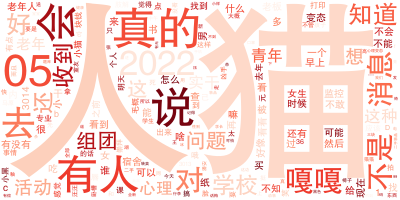

In [62]:
# 将全模式分词的结果合并成一个list
message_list = message_df.groupby("id").agg(collect_list('cut_all').alias('cut_all_list')).rdd.collect()
words = str(message_list[0]["cut_all_list"]).replace("[", "").replace("]", "").replace("'", "").split(", ")
# 统计词频
words_df = sc.parallelize(words).map(lambda x: (x, 1)).reduceByKey(add).toDF(schema=["word", "frequency"])
word_frequency = words_df.rdd.map(lambda word: (word["word"], word["frequency"])).filter(filter_dict).collect()
word_frequency_dict = {}
for i in word_frequency:
    word_frequency_dict[i[0]] = i[1]

# 生成词云
wc = WordCloud(font_path="./fonts/FangZhengHeiTiJianTi-1.ttf",
               background_color='#FFFFFF', colormap="Reds", repeat=True)

wc.fit_words(word_frequency_dict)
wc.to_image()